# July 18,19, 2022: Trial level responses in the MAX paradigm: exploratory dataset
MAX paradigm: simple block design paradigm to study anxious apprehension by contrasting threat and safe conditions. 
Threat is painful electrical stimulation and safe is a mild electric vibration.

The fMRI time series dataset may be contanimated with 1. head motion artifacts, 2. hemodynamic lags of the previous events. 
More explicitly, if you convolve a boxcar of a trial you will see that the response from the rating period spills over into the next trial, so the response is mixed.
If the responses are mixed, you're not evaluating functional connectivity that is related to the condition only but it's mixed.
It is desirable to remove noise from the signal and get responses at each trial (a block of a condition).

This trial level analysis for all ROIs was done by V.P.S. Murty, and I am extracting the responses from his analysis.

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import pickle, random
from tqdm import tqdm

# plotting
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr #CITE ITS PAPER IN YOUR MANUSCRIPT

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/jul22"

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils as dataset_utils

In [2]:
main_data_dir = (
    f"/home/govindas/vscode-BSWIFT-mnt/MAX/dataset/first_level"
    f"/ROI_old/neutral_runs_conditionLevel_FNSandFNT_trialLevel/MAX_ROIs_final_gm_85"
)

class ARGS(): pass
args = ARGS()

args.TRIAL_LEN = 14
args.LABELS = [0, 1] #safe, threat
args.LABEL_NAMES = ['FNS#', 'FNT#']

args.SEED = 74
np.random.seed(args.SEED)

args.subjects = os.listdir(main_data_dir)[:-1] # exclude `txtfiles` subfolder
random.Random(args.SEED).shuffle(args.subjects)

## exploratory data

In [3]:
'''
exploratory dataset
'''
args.explor_subjects = args.subjects[ : round(0.25 * len(args.subjects))]
X = dataset_utils.get_max_trial_level_responses(
    args, 
    main_data_dir,
    args.explor_subjects
)

100%|██████████| 27/27 [00:07<00:00,  3.82it/s]


In [4]:
with open(f"{proj_dir}/data/max/exploratory_data_trial_level_responses.pkl", 'wb') as f:
    pickle.dump(X, f)

In [5]:
for label in args.LABELS:
    for x in X[label]:
        print(x.shape, x.dtype)

(16, 14, 85) float32
(16, 14, 85) float32
(11, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(11, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(11, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(11, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(11, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(16, 14, 85) float32
(11, 14, 85) float32
(16, 14, 85) 

## plotting the data

In [6]:
num_rois = 85
args.roi_idxs = np.arange(num_rois)

In [26]:
def plot_roi_time_series(args, X, savefig=False, fig_file=None):
    X_conds = {}
    X_ = {}
    for label in args.LABELS:
        X_[label] = np.concatenate(X[label], axis=0)
        X_conds[f"{label}_m"] = np.nanmean(X_[label], axis=0)
        X_conds[f"{label}_s"] = 1.96 * np.std(X_[label], axis=0) / np.sqrt(X_[label].shape[0])

    roi_name_file = (
        f"{os.environ['HOME']}/parcellations/MAX_85_ROI_masks/ROI_names.txt"
    )
    roi_names = pd.read_csv(roi_name_file, names=['roi_name']).values.squeeze()

    time = np.arange(X_[0].shape[1])
    names = ['safe', 'threat']
    colors = {0:'royalblue', 1:'firebrick'}
    nrows, ncols = int(np.ceil(len(args.roi_idxs)/5)), 5

    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(5*ncols, 4*nrows), 
        sharex=False, 
        sharey=True, 
        dpi=150
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    for idx, roi in enumerate(args.roi_idxs):
        roi_name = roi_names[roi]
        if nrows > 1:
            ax = axs[idx//ncols, np.mod(idx,ncols)]
        else:
            ax = axs[idx]

        ax.set_title(f"{roi} {roi_name}")
        for label in args.LABELS:
            ts_mean = X_conds[f"{label}_m"][:, idx]
            ts_std = X_conds[f"{label}_s"][:, idx]

            ax.plot(ts_mean, color=colors[label], label=names[label])

            ax.fill_between(
                time, 
                (ts_mean - ts_std), 
                (ts_mean + ts_std),
                alpha=0.3, color=colors[label],
            )
        ax.set_xlabel(f"time")
        ax.set_ylabel(f"roi resp.")
        ax.grid(True)
        ax.legend()

    if savefig:
        fig.savefig(
            fig_file,
            dpi=150,
            format='png',
            bbox_inches='tight',
            transparent=False
        )
    
    return X_, X_conds

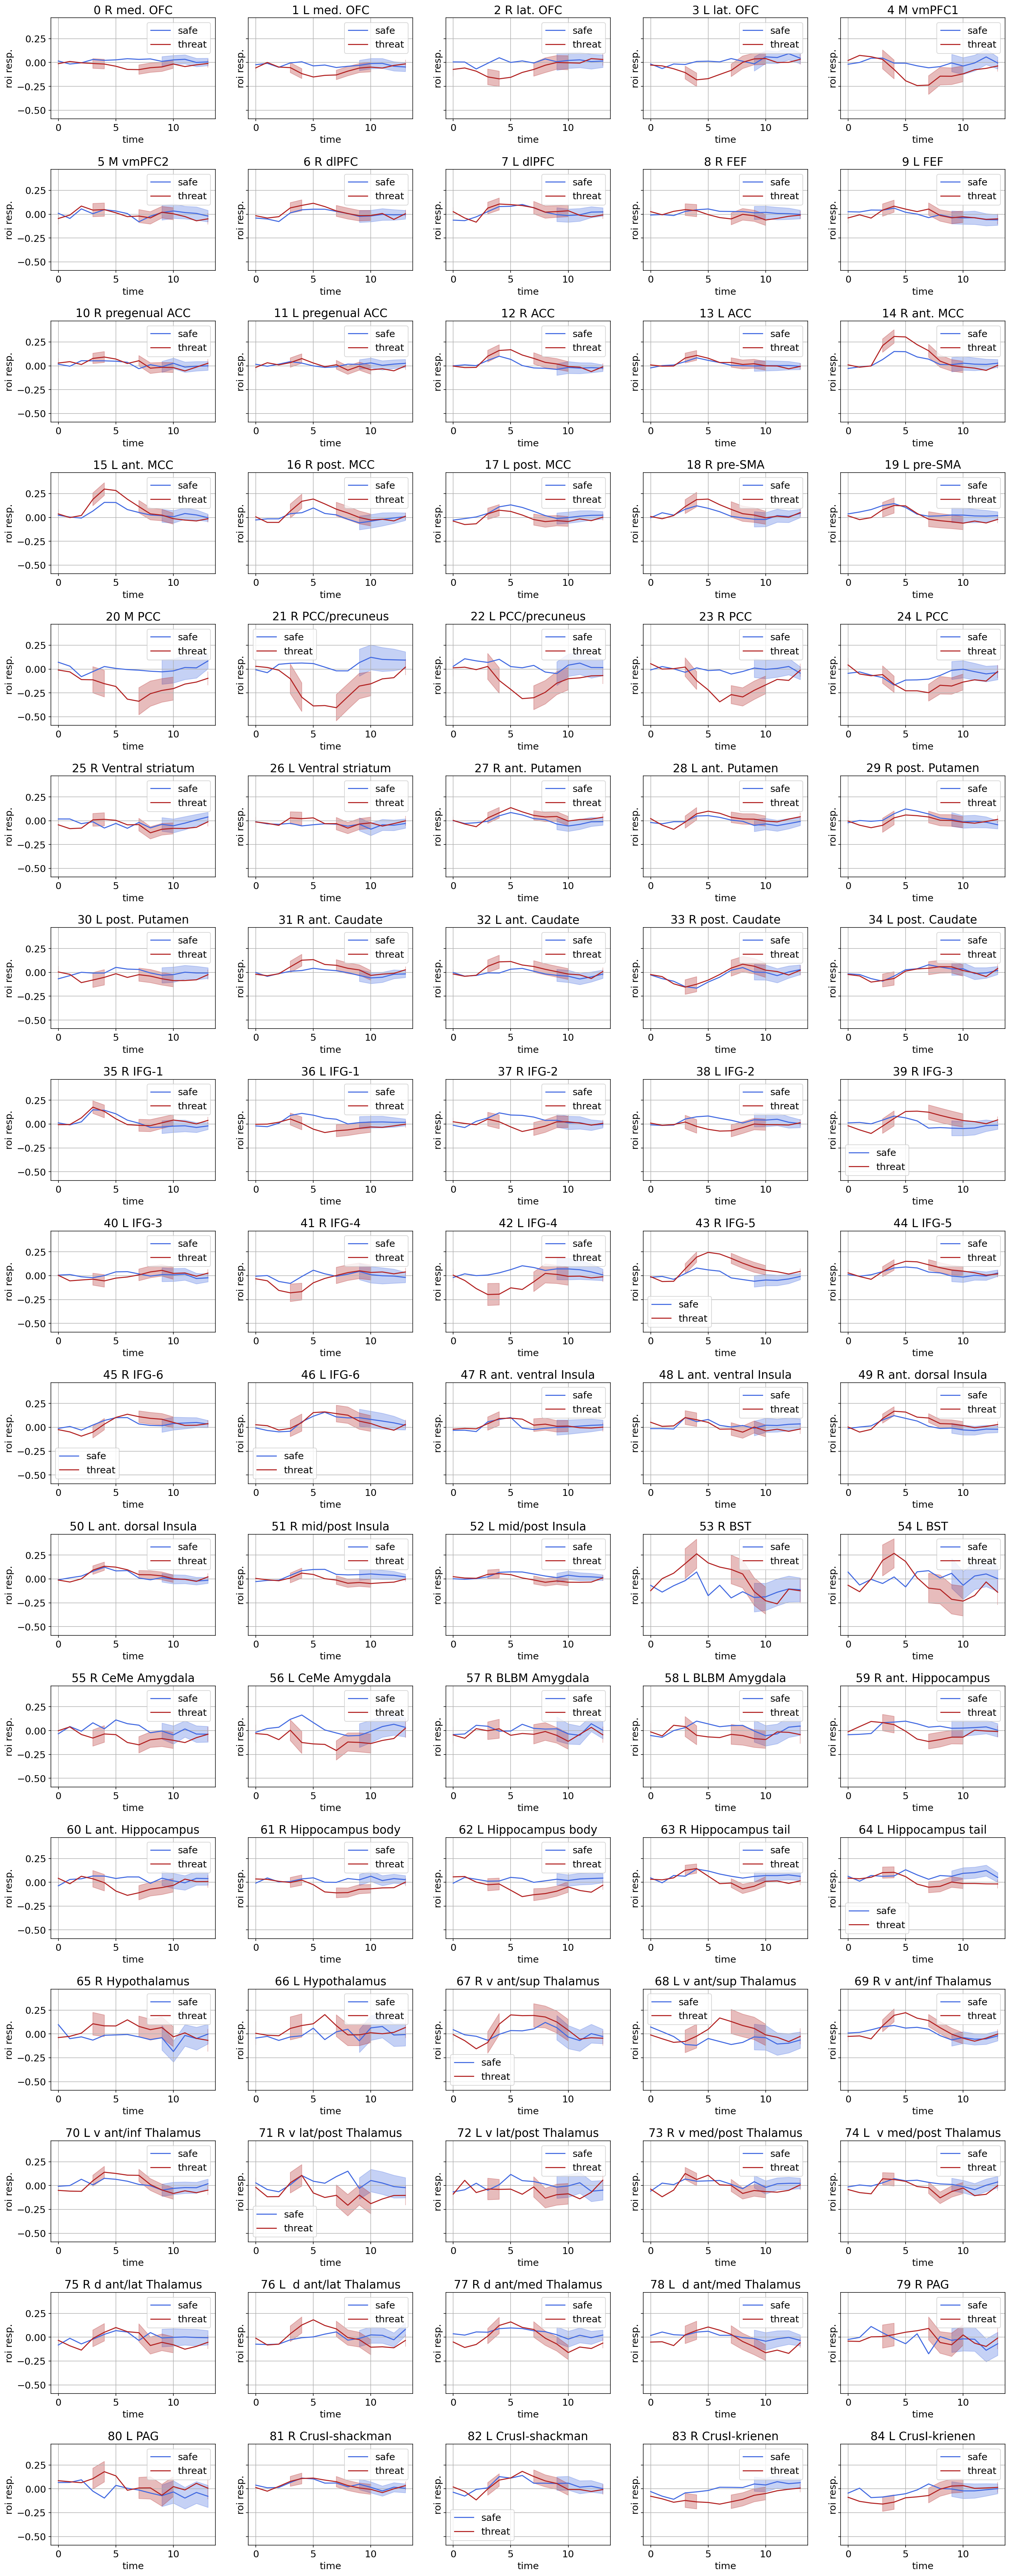

In [27]:
X_, X_conds = plot_roi_time_series(args, X)

In [35]:
X_conds['0_m'][:, 0]

array([ 0.01579564, -0.01595713, -0.00345584,  0.03149675,  0.02277683,
        0.02781078,  0.03992864,  0.03284505,  0.03761521,  0.01209768,
        0.02735722,  0.03369704,  0.0005385 ,  0.00650582], dtype=float32)